In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo")
import turing as tu
from turing.utils import *
import turing.loss_functions as tu_loss

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
#layers = [3, 64, 64, 64, 64, 2]
layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x_domain = L*np.linspace(0,1,x_size)
y_domain = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

boundary_x_LB = np.concatenate((x_domain, 
                                np.repeat(x_domain[0], y_size)))
boundary_x_RT = np.concatenate((x_domain, 
                                np.repeat(x_domain[-1], y_size))) 

boundary_y_LB = np.concatenate((np.repeat(y_domain[0], x_size),
                                y_domain))
boundary_y_RT = np.concatenate((np.repeat(y_domain[-1], x_size),
                                y_domain)) 

boundary_XX_LB = np.tile(boundary_x_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_XX_RT = np.tile(boundary_x_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_LB = np.tile(boundary_y_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_RT = np.tile(boundary_y_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_TT = np.repeat(t_star[-T:], (x_size + y_size))[:, np.newaxis] # T x (x_size + y_size), 1


def create_dataset(training_data_size =  T*16,
                   pde_data_size =  (T*N)//(32),
                   boundary_data_size = ((x_size + y_size)*T)//(8),
                   with_boundary = True,
                   signal_to_noise = 0):
    
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_a = (np.max(AA)-np.min(AA))/2.0
        signal_amp_s = (np.max(SS)-np.min(SS))/2.0  
        sigma_a =  signal_amp_a*signal_to_noise
        sigma_s =  signal_amp_s*signal_to_noise
    # Observed data
    idx_data = np.random.choice(N*T, training_data_size, replace=False)
    # PDE colocations
    idx_pde = np.random.choice(N*T, pde_data_size, replace=False)
    # Periodic boundary condition
    idx_boundary = np.random.choice((x_size + y_size)*T, boundary_data_size, replace=False)
    
    ret = {'obs_input': np.c_[XX[idx_data], YY[idx_data],TT[idx_data]],
           'obs_output': np.c_[AA[idx_data], SS[idx_data]],
           'pde':   np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]]}
    
    if signal_to_noise > 0:        
        ret['obs_output'][0] += sigma_a * np.random.randn(len(idx_data), a.shape[1])
        ret['obs_output'][1] += sigma_s * np.random.randn(len(idx_data), s.shape[1])
    
    if with_boundary:
        ret = {**ret,
               **{'boundary_LB': np.c_[boundary_XX_LB[idx_boundary], 
                                       boundary_YY_LB[idx_boundary],
                                       boundary_TT[idx_boundary]],
                  'boundary_RT': np.c_[boundary_XX_RT[idx_boundary],
                                       boundary_YY_RT[idx_boundary],
                                       boundary_TT[idx_boundary]]
                 }
              }
    return ret



In [4]:
model_params_1 = {'training_data_size': T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(**model_params_1)
lb, ub = lower_upper_bounds([np.c_[XX, YY, TT]])
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']

In [40]:
pinn = tu.NN(layers, lb, ub)
loss_stack_1 = [tu_loss.Observations(pinn, obs_X, obs_Y, init_loss_weight = 1.0)
               ]
model_1 = tu.TINN(pinn, loss_stack_1, optimizer=keras.optimizers.Adam())

In [41]:
arr_losses_1, samples_params_1, _ = \
         model_1.train(10000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=False,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:23519.45
Loss_observations:23519.45199585 
Time:0.55

Epoch: 100, loss:4336.93
Loss_observations:4336.92709351 
Time:42.22

Epoch: 200, loss:4339.04
Loss_observations:4339.04153442 
Time:41.70

Epoch: 300, loss:4333.80
Loss_observations:4333.80465698 
Time:39.97

Epoch: 400, loss:4334.37
Loss_observations:4334.36752319 
Time:38.60

Epoch: 500, loss:4335.37
Loss_observations:4335.37423706 
Time:39.83

Epoch: 600, loss:4333.99
Loss_observations:4333.98861694 
Time:37.73

Epoch: 700, loss:4329.75
Loss_observations:4329.75277710 
Time:41.51

Epoch: 800, loss:4317.90
Loss_observations:4317.90124512 
Time:42.06

Epoch: 900, loss:4312.44
Loss_observations:4312.43551636 
Time:43.88

Epoch: 1000, loss:4311.50
Loss_observations:4311.49810791 
Time:43.03

Epoch: 1100, loss:4286.30
Loss_observations:4286.30169678 
Time:41.68

Epoch: 1200, loss:4226.00
Loss_observations:4225.99966431 
Time:41.86

Epoch: 1300, loss:4034.62
Loss_observations:4034.61952209 
Time:39.96

Epoch: 1400, loss

In [51]:
arr_losses_11, samples_params_11, _ = \
         model_1.train(5000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=False,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:0.93
Loss_observations:0.93259449 
Time:0.26

###############################################
#           Early Stop                        #
###############################################
Epoch: 1, loss:0.93
Loss_observations:0.93259449 

Time:0.00



In [13]:
pinn_2 = pinn.copy()
loss_stack_2 = [tu_loss.Observations(pinn_2, obs_X, obs_Y, init_loss_weight = 1.0),
                tu_loss.ASDM(pinn_2, pde_X, init_loss_weight = 1.0)
               ]
model_2 = tu.TINN(pinn_2, loss_stack_2, optimizer=keras.optimizers.Adam())

In [14]:
arr_losses_2, samples_params_2, samples_grads_2 = \
         model_2.train(3000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=True,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=True)

Epoch: 1, loss:9559.24
Loss_observations:1887.38503103 
Loss_ASDM:7671.85922241 sigma_a:0:0.98443222, sigma_s:0:0.98481154, rho_a:0:0.98389465, rho_s:0:1.01589704, mu_a:0:1.01606083, kappa_a:0:0.99530989
Time:6.55

Epoch: 100, loss:1811.61
Loss_observations:885.06687546 
Loss_ASDM:926.54227448 sigma_a:0:0.38856682, sigma_s:0:0.65419638, rho_a:0:0.87165934, rho_s:0:0.90140283, mu_a:0:0.96772224, kappa_a:0:0.68799347
Time:167.51

Epoch: 200, loss:246.45
Loss_observations:102.69478464 
Loss_ASDM:143.75314045 sigma_a:0:0.00000000, sigma_s:0:0.06843941, rho_a:0:0.92506182, rho_s:0:0.06012829, mu_a:0:1.04157174, kappa_a:0:0.14629115
Time:173.71

Epoch: 300, loss:214.63
Loss_observations:94.59468651 
Loss_ASDM:120.03099012 sigma_a:0:0.00000000, sigma_s:0:0.06519475, rho_a:0:1.05917561, rho_s:0:0.05816231, mu_a:0:1.18651450, kappa_a:0:0.15477374
Time:171.47

Epoch: 400, loss:196.05
Loss_observations:86.61808157 
Loss_ASDM:109.43607807 sigma_a:0:0.00784861, sigma_s:0:0.06542288, rho_a:0:1.20960

In [15]:
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

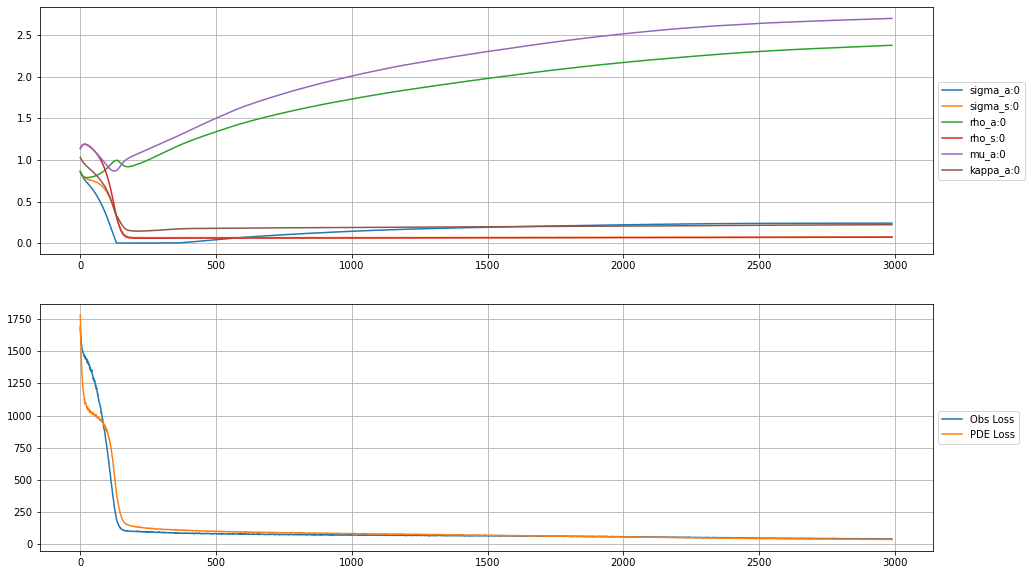

In [17]:
start = 10

_ = plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_2[start:,j], label=f"{param_names[j]}")
    
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(2,1,2)
plt.plot(arr_losses_2[start:,0], label="Obs Loss")
plt.plot(arr_losses_2[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [19]:
pinn_3 = tu.NN(layers, lb, ub)
loss_stack_3 = [tu_loss.Observations(pinn_3,obs_X, obs_Y),
                tu_loss.ASDM(pinn_3, pde_X,
                             sigma_a = loss_stack_2[1].sigma_a.numpy()[0],
                             sigma_s = loss_stack_2[1].sigma_s.numpy()[0],
                             mu_a = loss_stack_2[1].mu_a.numpy()[0],
                             rho_a = loss_stack_2[1].rho_a.numpy()[0],
                             rho_s = loss_stack_2[1].rho_s.numpy()[0],
                             kappa_a = loss_stack_2[1].kappa_a.numpy()[0])
           ]

model_3 = tu.TINN(pinn_3, 
                  loss_stack_3, 
                  #optimizer=keras.optimizers.SGD(learning_rate=1e-6),
                  optimizer=keras.optimizers.Adam(),
                  fixed_loss_params=False,
                  fixed_pinn=False)

In [20]:
arr_losses_3, samples_params_3, samples_grads_3 = \
         model_3.train(1000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=True,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=True)

Epoch: 1, loss:36313.13
Loss_observations:35453.41760254 
Loss_ASDM:859.71182680 sigma_a:0:0.23453191, sigma_s:0:0.05641089, rho_a:0:2.39037132, rho_s:0:0.08416954, mu_a:0:2.69213843, kappa_a:0:0.20995541
Time:6.38

Epoch: 100, loss:4344.17
Loss_observations:4339.45974731 
Loss_ASDM:4.71249084 sigma_a:0:0.25734708, sigma_s:0:0.04864499, rho_a:0:2.37906575, rho_s:0:0.04763816, mu_a:0:2.67836428, kappa_a:0:0.24963787
Time:182.07

Epoch: 200, loss:4347.58
Loss_observations:4344.05624390 
Loss_ASDM:3.52778046 sigma_a:0:0.28161082, sigma_s:0:0.03443360, rho_a:0:2.38103223, rho_s:0:0.03249662, mu_a:0:2.65757632, kappa_a:0:0.27346516
Time:186.82

Epoch: 300, loss:4342.92
Loss_observations:4338.65057373 
Loss_ASDM:4.26608515 sigma_a:0:0.30824006, sigma_s:0:0.01897747, rho_a:0:2.37924337, rho_s:0:0.01976363, mu_a:0:2.64100957, kappa_a:0:0.29698303
Time:186.45

Epoch: 400, loss:4342.27
Loss_observations:4340.88272095 
Loss_ASDM:1.39162784 sigma_a:0:0.33126640, sigma_s:0:0.00790401, rho_a:0:2.376

In [21]:
arr_losses_4, samples_params_4, samples_grads_4 = \
         model_3.train(3000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=True,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=True)

Epoch: 1, loss:4255.19
Loss_observations:4245.02600098 
Loss_ASDM:10.16395521 sigma_a:0:0.39224559, sigma_s:0:0.02664906, rho_a:0:2.33879924, rho_s:0:0.02684295, mu_a:0:2.58875704, kappa_a:0:0.35201830
Time:1.85

Epoch: 100, loss:4108.85
Loss_observations:4094.00888062 
Loss_ASDM:14.84190667 sigma_a:0:0.36155200, sigma_s:0:0.03945801, rho_a:0:2.30846238, rho_s:0:0.04008174, mu_a:0:2.59716392, kappa_a:0:0.30800366
Time:206.99

Epoch: 200, loss:4006.56
Loss_observations:3986.85847473 
Loss_ASDM:19.70503461 sigma_a:0:0.38332906, sigma_s:0:0.03616850, rho_a:0:2.28242183, rho_s:0:0.03730447, mu_a:0:2.59125996, kappa_a:0:0.30985191
Time:193.68

Epoch: 300, loss:3964.60
Loss_observations:3938.13937378 
Loss_ASDM:26.46537387 sigma_a:0:0.38133636, sigma_s:0:0.04165096, rho_a:0:2.25991130, rho_s:0:0.04337441, mu_a:0:2.59114432, kappa_a:0:0.29344878
Time:200.63

Epoch: 400, loss:3766.67
Loss_observations:3733.95585632 
Loss_ASDM:32.71829760 sigma_a:0:0.39159501, sigma_s:0:0.04049455, rho_a:0:2.23

In [24]:
samples_params = np.vstack((samples_params_3,samples_params_4))
arr_losses = np.vstack((arr_losses_3,arr_losses_4))

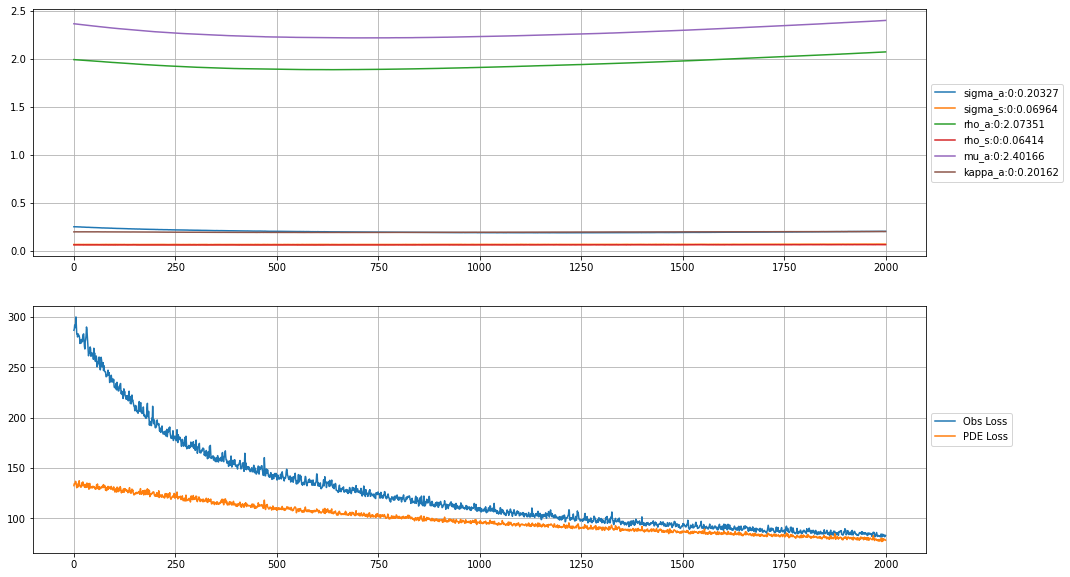

In [28]:
start = 2000
asdm = loss_stack_3[1]
_ = plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params[start:,j], label=f"{param_names[j]}:{asdm.trainable_vars()[j].numpy()[0]:.5f}")
    
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(2,1,2)
plt.plot(arr_losses[start:,0], label="Obs Loss")
plt.plot(arr_losses[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [68]:
pinn_t = pinn.copy()
loss_stack_t = [tu_loss.Observations(pinn_t, obs_X, obs_Y, init_loss_weight = 1.0),
                tu_loss.ASDM(pinn_t, pde_X, init_loss_weight = 1.0,
                            sigma_a = 0.0/0.005,
                             sigma_s = 0.02/0.2,
                             mu_a = 0.01/0.005,
                             rho_a = 0.01/0.005,
                             rho_s = 0.02/0.2,
                             kappa_a = 0.25)
               ]
model_t = tu.TINN(pinn_t, loss_stack_t, optimizer=keras.optimizers.Adam(), fixed_loss_params=False)

In [69]:
arr_losses_t, samples_params_t, samples_grads_t = \
         model_t.train(1000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=50,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=True,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:516.62
Loss_observations:100.65502807 
Loss_ASDM:415.96049690 sigma_a:0:0.00812443, sigma_s:0:0.09089283, rho_a:0:1.99766243, rho_s:0:0.09057379, mu_a:0:2.00045657, kappa_a:0:0.25454831
Time:6.96

Epoch: 50, loss:171.20
Loss_observations:68.78440905 
Loss_ASDM:102.41214418 sigma_a:0:0.11311513, sigma_s:0:0.06520959, rho_a:0:1.92669845, rho_s:0:0.06288688, mu_a:0:2.08310509, kappa_a:0:0.23178329
Time:118.69

Epoch: 100, loss:155.72
Loss_observations:67.95438004 
Loss_ASDM:87.76314402 sigma_a:0:0.14288571, sigma_s:0:0.06565370, rho_a:0:1.91024303, rho_s:0:0.06371645, mu_a:0:2.14381337, kappa_a:0:0.21122061
Time:117.45

Epoch: 150, loss:144.02
Loss_observations:66.04915166 
Loss_ASDM:77.97081900 sigma_a:0:0.15466344, sigma_s:0:0.06703715, rho_a:0:1.91988468, rho_s:0:0.06319854, mu_a:0:2.18032789, kappa_a:0:0.20530282
Time:118.86

Epoch: 200, loss:136.48
Loss_observations:62.81736493 
Loss_ASDM:73.65763712 sigma_a:0:0.16123469, sigma_s:0:0.06785617, rho_a:0:1.93787730, rho_s

In [70]:
arr_losses_t, samples_params_t, samples_grads_t = \
         model_t.train(12000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=50,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=True,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:49.26
Loss_observations:26.61249876 
Loss_ASDM:22.64899838 sigma_a:0:0.14075442, sigma_s:0:0.08017872, rho_a:0:2.22259045, rho_s:0:0.07839009, mu_a:0:2.41885448, kappa_a:0:0.23005654
Time:2.13

Epoch: 50, loss:48.22
Loss_observations:25.83205223 
Loss_ASDM:22.38738489 sigma_a:0:0.14044711, sigma_s:0:0.08111715, rho_a:0:2.23189569, rho_s:0:0.07884747, mu_a:0:2.42483974, kappa_a:0:0.23116513
Time:124.80

Epoch: 100, loss:45.73
Loss_observations:24.69914234 
Loss_ASDM:21.03539920 sigma_a:0:0.13978143, sigma_s:0:0.08177368, rho_a:0:2.24050140, rho_s:0:0.07914110, mu_a:0:2.43089151, kappa_a:0:0.23195502
Time:122.55

Epoch: 150, loss:46.55
Loss_observations:25.04993343 
Loss_ASDM:21.49574745 sigma_a:0:0.13950819, sigma_s:0:0.08181780, rho_a:0:2.24818373, rho_s:0:0.08006450, mu_a:0:2.43681574, kappa_a:0:0.23269105
Time:123.48

Epoch: 200, loss:42.84
Loss_observations:22.70096552 
Loss_ASDM:20.13626647 sigma_a:0:0.13963364, sigma_s:0:0.08266386, rho_a:0:2.25531769, rho_s:0:0.079

Epoch: 1950, loss:16.39
Loss_observations:8.46183258 
Loss_ASDM:7.92413545 sigma_a:0:0.11298468, sigma_s:0:0.08991081, rho_a:0:2.31873012, rho_s:0:0.08792244, mu_a:0:2.45096397, kappa_a:0:0.24638225
Time:124.66

Epoch: 2000, loss:18.07
Loss_observations:9.17333651 
Loss_ASDM:8.89338872 sigma_a:0:0.11230110, sigma_s:0:0.09043956, rho_a:0:2.31814623, rho_s:0:0.08800720, mu_a:0:2.44918990, kappa_a:0:0.24666466
Time:124.15

Epoch: 2050, loss:17.30
Loss_observations:8.51670402 
Loss_ASDM:8.78522119 sigma_a:0:0.11154490, sigma_s:0:0.09082624, rho_a:0:2.31769347, rho_s:0:0.08808696, mu_a:0:2.44731545, kappa_a:0:0.24684076
Time:127.61

Epoch: 2100, loss:16.64
Loss_observations:8.37440735 
Loss_ASDM:8.26479772 sigma_a:0:0.11120670, sigma_s:0:0.09038004, rho_a:0:2.31700420, rho_s:0:0.08846115, mu_a:0:2.44544482, kappa_a:0:0.24695390
Time:129.71

Epoch: 2150, loss:17.72
Loss_observations:8.67923915 
Loss_ASDM:9.03716269 sigma_a:0:0.11060512, sigma_s:0:0.09050958, rho_a:0:2.31617641, rho_s:0:0.088

Epoch: 3900, loss:9.43
Loss_observations:4.48047490 
Loss_ASDM:4.94816068 sigma_a:0:0.08294004, sigma_s:0:0.09356861, rho_a:0:2.25015116, rho_s:0:0.09121255, mu_a:0:2.34166670, kappa_a:0:0.25087741
Time:125.10

Epoch: 3950, loss:10.36
Loss_observations:4.90952453 
Loss_ASDM:5.44998229 sigma_a:0:0.08216538, sigma_s:0:0.09357660, rho_a:0:2.24782157, rho_s:0:0.09124613, mu_a:0:2.33850694, kappa_a:0:0.25104016
Time:123.85

Epoch: 4000, loss:10.74
Loss_observations:4.83590761 
Loss_ASDM:5.89940423 sigma_a:0:0.08184213, sigma_s:0:0.09385987, rho_a:0:2.24524283, rho_s:0:0.09118448, mu_a:0:2.33480048, kappa_a:0:0.25110659
Time:128.78

Epoch: 4050, loss:11.17
Loss_observations:5.10335344 
Loss_ASDM:6.06761551 sigma_a:0:0.08121611, sigma_s:0:0.09408704, rho_a:0:2.24273562, rho_s:0:0.09121708, mu_a:0:2.33162642, kappa_a:0:0.25105396
Time:130.56

Epoch: 4100, loss:10.59
Loss_observations:4.92806271 
Loss_ASDM:5.66577569 sigma_a:0:0.08035779, sigma_s:0:0.09387664, rho_a:0:2.24051332, rho_s:0:0.0915

Epoch: 5850, loss:8.62
Loss_observations:3.84141538 
Loss_ASDM:4.78316396 sigma_a:0:0.05762561, sigma_s:0:0.09498442, rho_a:0:2.15624022, rho_s:0:0.09247288, mu_a:0:2.21920252, kappa_a:0:0.25200015
Time:137.40

Epoch: 5900, loss:8.37
Loss_observations:3.71551627 
Loss_ASDM:4.65893501 sigma_a:0:0.05679823, sigma_s:0:0.09490715, rho_a:0:2.15414238, rho_s:0:0.09251076, mu_a:0:2.21654940, kappa_a:0:0.25200903
Time:140.24

Epoch: 5950, loss:7.30
Loss_observations:3.39590140 
Loss_ASDM:3.90621217 sigma_a:0:0.05648588, sigma_s:0:0.09495497, rho_a:0:2.15181851, rho_s:0:0.09238135, mu_a:0:2.21346521, kappa_a:0:0.25222936
Time:138.34

Epoch: 6000, loss:7.58
Loss_observations:3.49275292 
Loss_ASDM:4.08645374 sigma_a:0:0.05619358, sigma_s:0:0.09499358, rho_a:0:2.14946628, rho_s:0:0.09225982, mu_a:0:2.21067882, kappa_a:0:0.25227749
Time:137.20

Epoch: 6050, loss:8.43
Loss_observations:3.75505623 
Loss_ASDM:4.67971958 sigma_a:0:0.05541208, sigma_s:0:0.09497754, rho_a:0:2.14741492, rho_s:0:0.09254390

Epoch: 7800, loss:7.90
Loss_observations:3.42804974 
Loss_ASDM:4.46950653 sigma_a:0:0.03879942, sigma_s:0:0.09533814, rho_a:0:2.07588601, rho_s:0:0.09259427, mu_a:0:2.11879897, kappa_a:0:0.25290057
Time:146.99

Epoch: 7850, loss:6.35
Loss_observations:2.86446761 
Loss_ASDM:3.49040478 sigma_a:0:0.03880055, sigma_s:0:0.09527796, rho_a:0:2.07393074, rho_s:0:0.09250551, mu_a:0:2.11603904, kappa_a:0:0.25297508
Time:138.08

Epoch: 7900, loss:7.10
Loss_observations:3.17488937 
Loss_ASDM:3.92383327 sigma_a:0:0.03805230, sigma_s:0:0.09524307, rho_a:0:2.07219911, rho_s:0:0.09279957, mu_a:0:2.11433673, kappa_a:0:0.25277039
Time:149.29

Epoch: 7950, loss:6.85
Loss_observations:3.05330317 
Loss_ASDM:3.79621655 sigma_a:0:0.03767369, sigma_s:0:0.09542383, rho_a:0:2.07032776, rho_s:0:0.09266667, mu_a:0:2.11210895, kappa_a:0:0.25280666
Time:135.94

Epoch: 8000, loss:7.77
Loss_observations:3.46623644 
Loss_ASDM:4.30819261 sigma_a:0:0.03754397, sigma_s:0:0.09493278, rho_a:0:2.06827569, rho_s:0:0.09294914

Epoch: 9750, loss:4.82
Loss_observations:2.33970195 
Loss_ASDM:2.47615480 sigma_a:0:0.02419343, sigma_s:0:0.09506383, rho_a:0:2.00911498, rho_s:0:0.09276933, mu_a:0:2.03574514, kappa_a:0:0.25358766
Time:138.76

Epoch: 9800, loss:4.85
Loss_observations:2.27966537 
Loss_ASDM:2.57178602 sigma_a:0:0.02418006, sigma_s:0:0.09530690, rho_a:0:2.00763440, rho_s:0:0.09230496, mu_a:0:2.03422618, kappa_a:0:0.25370759
Time:139.20

Epoch: 9850, loss:6.28
Loss_observations:2.66836376 
Loss_ASDM:3.61016352 sigma_a:0:0.02413084, sigma_s:0:0.09531125, rho_a:0:2.00596189, rho_s:0:0.09273157, mu_a:0:2.03232789, kappa_a:0:0.25379288
Time:136.79

Epoch: 9900, loss:5.99
Loss_observations:2.65016332 
Loss_ASDM:3.34102868 sigma_a:0:0.02346651, sigma_s:0:0.09527511, rho_a:0:2.00466228, rho_s:0:0.09250828, mu_a:0:2.03068447, kappa_a:0:0.25354412
Time:140.44

Epoch: 9950, loss:6.20
Loss_observations:2.80807227 
Loss_ASDM:3.39564949 sigma_a:0:0.02355110, sigma_s:0:0.09499819, rho_a:0:2.00319481, rho_s:0:0.09277926

Epoch: 11700, loss:4.84
Loss_observations:2.22526969 
Loss_ASDM:2.61669970 sigma_a:0:0.01252445, sigma_s:0:0.09486797, rho_a:0:1.95274258, rho_s:0:0.09284218, mu_a:0:1.96637344, kappa_a:0:0.25418541
Time:142.43

Epoch: 11750, loss:6.27
Loss_observations:2.87779047 
Loss_ASDM:3.39276184 sigma_a:0:0.01231601, sigma_s:0:0.09495106, rho_a:0:1.95150220, rho_s:0:0.09265095, mu_a:0:1.96476579, kappa_a:0:0.25425002
Time:145.96

Epoch: 11800, loss:3.26
Loss_observations:1.67447160 
Loss_ASDM:1.58959814 sigma_a:0:0.01157942, sigma_s:0:0.09484664, rho_a:0:1.94974124, rho_s:0:0.09274161, mu_a:0:1.96233141, kappa_a:0:0.25435594
Time:145.22

Epoch: 11850, loss:4.72
Loss_observations:2.18316712 
Loss_ASDM:2.53414421 sigma_a:0:0.01164504, sigma_s:0:0.09462880, rho_a:0:1.94902551, rho_s:0:0.09290545, mu_a:0:1.96144068, kappa_a:0:0.25432694
Time:146.05

Epoch: 11900, loss:5.03
Loss_observations:2.27582598 
Loss_ASDM:2.75880817 sigma_a:0:0.01140083, sigma_s:0:0.09501904, rho_a:0:1.94782615, rho_s:0:0.092

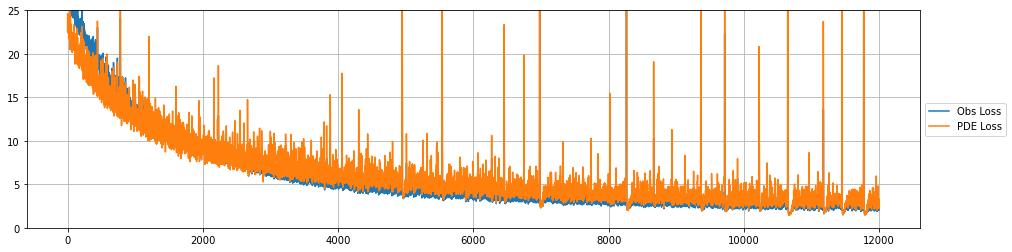

In [74]:
_ = plt.figure(figsize=(16,4))
plt.plot(arr_losses_t[0:,0], label="Obs Loss")
plt.plot(arr_losses_t[0:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,25])
plt.show()

In [67]:
arr_losses_t, samples_params_t, samples_grads_t = \
         model_t.train(1000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=50,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=True,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:523.92
Loss_observations:110.71276205 
Loss_ASDM:413.20272064 sigma_a:0:0.00000000, sigma_s:0:0.10000000, rho_a:0:2.00000000, rho_s:0:0.10000000, mu_a:0:2.00000000, kappa_a:0:0.25000000
Time:6.58

Epoch: 50, loss:190.08
Loss_observations:66.55969596 
Loss_ASDM:123.51624393 sigma_a:0:0.00000000, sigma_s:0:0.10000000, rho_a:0:2.00000000, rho_s:0:0.10000000, mu_a:0:2.00000000, kappa_a:0:0.25000000
Time:110.24

Epoch: 100, loss:171.10
Loss_observations:65.12439752 
Loss_ASDM:105.97514868 sigma_a:0:0.00000000, sigma_s:0:0.10000000, rho_a:0:2.00000000, rho_s:0:0.10000000, mu_a:0:2.00000000, kappa_a:0:0.25000000
Time:118.82

Epoch: 150, loss:157.46
Loss_observations:65.19132996 
Loss_ASDM:92.26731968 sigma_a:0:0.00000000, sigma_s:0:0.10000000, rho_a:0:2.00000000, rho_s:0:0.10000000, mu_a:0:2.00000000, kappa_a:0:0.25000000
Time:121.00

Epoch: 200, loss:141.54
Loss_observations:60.52709794 
Loss_ASDM:81.00993252 sigma_a:0:0.00000000, sigma_s:0:0.10000000, rho_a:0:2.00000000, rho_

In [61]:
arr_losses_t, samples_params_t, samples_grads_t = \
         model_t.train(1000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=50,
                       stop_threshold = 1.0,
                       avg_window=0,
                       regularised=False,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:595.40
Loss_observations:109.26431679 
Loss_ASDM:486.13296509 sigma_a:0:0.00000000, sigma_s:0:0.10000000, rho_a:0:2.00000000, rho_s:0:0.10000000, mu_a:0:2.00000000, kappa_a:0:0.25000000
Time:1.93

Epoch: 50, loss:23321.03
Loss_observations:8008.56604004 
Loss_ASDM:15312.46173096 sigma_a:0:0.00000000, sigma_s:0:0.10000000, rho_a:0:2.00000000, rho_s:0:0.10000000, mu_a:0:2.00000000, kappa_a:0:0.25000000
Time:48.03

Epoch: 100, loss:26255.31
Loss_observations:5219.16342163 
Loss_ASDM:21036.14934540 sigma_a:0:0.00000000, sigma_s:0:0.10000000, rho_a:0:2.00000000, rho_s:0:0.10000000, mu_a:0:2.00000000, kappa_a:0:0.25000000
Time:48.48

Epoch: 150, loss:54496.25
Loss_observations:4950.90447998 
Loss_ASDM:49545.34259033 sigma_a:0:0.00000000, sigma_s:0:0.10000000, rho_a:0:2.00000000, rho_s:0:0.10000000, mu_a:0:2.00000000, kappa_a:0:0.25000000
Time:46.13

Epoch: 200, loss:81613.50
Loss_observations:5114.15539551 
Loss_ASDM:76499.34667969 sigma_a:0:0.00000000, sigma_s:0:0.10000000, r

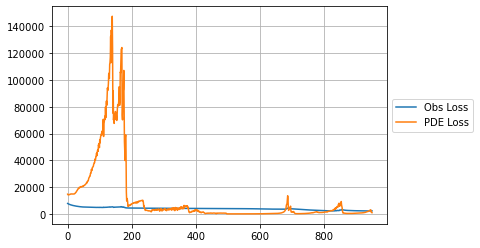

In [63]:
start=50
plt.plot(arr_losses_t[start:,0], label="Obs Loss")
plt.plot(arr_losses_t[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()